In [19]:
import sys
sys.path.append('/NDDepth/Estimation/nddepth_custom')

In [20]:
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
from networks.NewCRFDepth import NewCRFDepth
from utils import post_process_depth, flip_lr, compute_errors

In [21]:
IMG_PATH = "/scratchdata/nyu_data/data/nyu2_test/00008_colors.png"
MODEL_PATH = "/scratchdata/nyu.pth"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


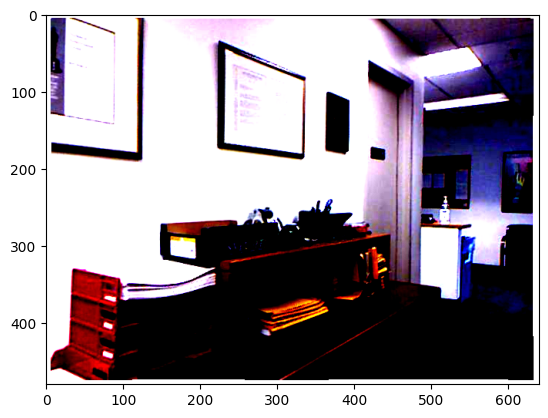

In [22]:
image = np.asarray(Image.open(IMG_PATH), dtype=np.float32) / 255.0

image = torch.from_numpy(image.transpose((2, 0, 1)))
image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)


plt.imshow(image.permute(1, 2, 0))

In [23]:
K = np.array([[518.8579 / 4.0, 0, 325.5824 / 4.0, 0],
            [0, 518.8579 / 4.0, 253.7362 / 4.0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]], dtype=np.float32) 
inv_K = np.linalg.pinv(K)
inv_K = torch.from_numpy(inv_K)

In [24]:
ENCODER = "large07"
MAX_DEPTH = 10
model = NewCRFDepth(version=ENCODER, inv_depth=False, max_depth=MAX_DEPTH, pretrained=None).to("cuda")
model.train()
num_params = sum([np.prod(p.size()) for p in model.parameters()])
print("== Total number of parameters: {}".format(num_params))

num_params_update = sum([np.prod(p.shape) for p in model.parameters() if p.requires_grad])
print("== Total number of learning parameters: {}".format(num_params_update))

model = torch.nn.DataParallel(model)
model.cuda()

print("== Model Initialized")
cudnn.benchmark = True


== Load encoder backbone from: None
== Total number of parameters: 348400139
== Total number of learning parameters: 348400139
== Model Initialized


In [25]:
EPOCH = 5
model.eval()
with torch.no_grad():
    image_torch = torch.Tensor(image.unsqueeze(0).cuda())
    inv_K_torch = torch.Tensor(inv_K.unsqueeze(0).cuda())

    depth1_list, uncer1_list, depth2_list, uncer2_list, normals, distances = model(image_torch, inv_K_torch, EPOCH)
    
    pred_depth = 0.5 * (depth1_list[-1] + depth2_list[-1])
    
    image_flipped = flip_lr(image_torch)
    depth1_list_flipped, uncer1_list_flipped, depth2_list_flipped, uncer2_list_flipped, normals_flipped, distances_flipped = model(image_flipped, inv_K_torch, EPOCH)
    pred_depth_flipped = 0.5 * (depth1_list_flipped[-1] + depth2_list_flipped[-1])
    pred_depth = post_process_depth(pred_depth, pred_depth_flipped)
    normals = (0.5 * (normals + 1)).permute(0, 2, 3, 1)

    pred_depth = pred_depth.cpu().numpy().squeeze()
    pred_normal = normals.cpu().numpy().squeeze()

In [26]:
print(pred_depth)

[[6.6290107 6.6290107 6.256355  ... 6.5928297 7.061468  7.061468 ]
 [6.6290107 6.6290107 6.256355  ... 6.5928297 7.061468  7.061468 ]
 [6.405819  6.405819  6.098856  ... 6.2975154 6.675609  6.675609 ]
 ...
 [4.786788  4.786788  4.949769  ... 6.943503  6.8001785 6.8001785]
 [4.9169645 4.9169645 5.064485  ... 7.062805  6.8722305 6.8722305]
 [4.9169645 4.9169645 5.064485  ... 7.062805  6.8722305 6.8722305]]


8.562139


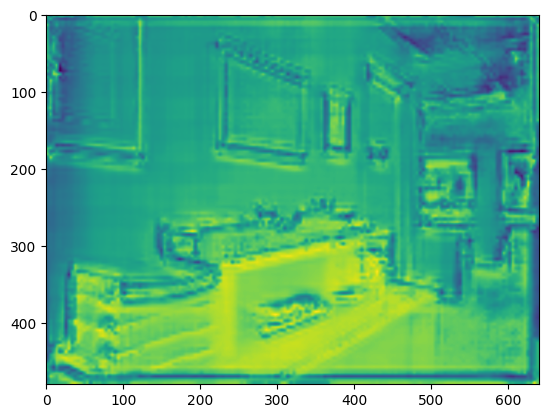

In [27]:
pred_depth = np.reshape(pred_depth, (480, 640))
print(pred_depth.max())
pred_depth = pred_depth / pred_depth.max()
plt.imshow(pred_depth)